## Dataset: Malicions & Benign URLs

This notebook will: 

1. Engineer features from the URL string such as profanity score, IP_present_binary, counts of various characters. 
2. Train different classification models: decision tree, random forest, gradient boosting, logistic regression
3. Save the best model to disk

In [1]:
import pandas as pd
import numpy as np
import math
import os
from tld import get_tld
from urllib.parse import urlparse

# Set working directory 
folder = r'C:\Users\hatzi\Documents\SUTD\Systems Security Project\Datasets\Malicious & Benign URLs'
os.chdir(folder)

In [2]:
# Import data
df = pd.read_csv("urldata.csv")
df = df.drop('Unnamed: 0',axis=1)

# Swap result labels as 0 -> malicious, 1 -> benign
df['label'].replace(to_replace ="benign", value =1, inplace=True)
df['label'].replace(to_replace ="malicious", value =0, inplace=True)
df['result'] = df['label'].astype(int)
df = df.drop('label', axis=1)
df.head()

,url,result
0,https://www.google.com,1
1,https://www.youtube.com,1
2,https://www.facebook.com,1
3,https://www.baidu.com,1
4,https://www.wikipedia.org,1


In [3]:
# See malicious (label == 0) examples
df[df['result'] == 0]

,url,result
345738,http://atualizacaodedados.online,0
345739,http://webmasteradmin.ukit.me/,0
345740,http://stcdxmt.bigperl.in/klxtv/apps/uk/,0
345741,https://tubuh-syarikat.com/plugins/fields/files/,0
345742,http://rolyborgesmd.com/exceword/excel.php?.ra...,0
...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,0
450172,http://faboleena.com/js/infortis/jquery/plugin...,0
450173,http://faboleena.com/js/infortis/jquery/plugin...,0
450174,http://atualizapj.com/,0


## Generating who_is features

Whois data is scrapped using another python file. 

In [4]:
# Break csv into 8 sets to run who_is scrapping
'''
file_index = 0
for subset in np.array_split(df, 8):
    file_index += 1
    filename = 'dataframe_' + str(file_index) + '.csv'
    print(filename, len(subset))
    subset.to_csv(filename)
'''

"\nfile_index = 0\nfor subset in np.array_split(df, 8):\n    file_index += 1\n    filename = 'dataframe_' + str(file_index) + '.csv'\n    print(filename, len(subset))\n    subset.to_csv(filename)\n"

In [2]:
# Import dataset after whois data scrapping
df = pd.read_csv("whois.csv")
df = df.drop('Unnamed: 0',axis=1)
# Swap result labels as 0 -> malicious, 1 -> benign
df['label'].replace(to_replace ="benign", value =1, inplace=True)
df['label'].replace(to_replace ="malicious", value =0, inplace=True)
df['result'] = df['label'].astype(int)
df = df.drop('label', axis=1)
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration
0,https://www.google.com,1,True,8772,743,2549
1,https://www.youtube.com,1,True,6062,250,146
2,https://www.facebook.com,1,True,8942,560,2381
3,https://www.baidu.com,1,True,8016,286,1845
4,https://www.wikipedia.org,1,True,7557,341,477


In [3]:
# See counts for whois_exist column
df['whois_exist'].value_counts()

True     347870
False    102306
Name: whois_exist, dtype: int64

In [4]:
# Set whois_exist to True if any of these columns are not -1
# days_since_creation, days_since_last_update, days_until_expiration
counter = 0
for index, row in df.iterrows():
    days_since_creation = row['days_since_creation']
    days_since_last_update = row['days_since_last_update']
    days_until_expiration = row['days_until_expiration']
    whois_exist = row['whois_exist']
    
    if whois_exist == False: 
        if (days_since_creation != -1) or (days_since_last_update != -1) or (days_until_expiration != -1): 
            # print(days_since_creation, days_since_last_update, days_until_expiration)
            # Set whois_exist to True as one of the values exist
            df.at[index,'whois_exist'] = True    
    
# See the new whois_exist counts
df['whois_exist'].value_counts()

True     348556
False    101620
Name: whois_exist, dtype: int64

### Generate other features

In [5]:
# URL Length feature
df['url_length'] = df['url'].apply(lambda x: len(str(x)))

In [6]:
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length
0,https://www.google.com,1,True,8772,743,2549,22
1,https://www.youtube.com,1,True,6062,250,146,23
2,https://www.facebook.com,1,True,8942,560,2381,24
3,https://www.baidu.com,1,True,8016,286,1845,21
4,https://www.wikipedia.org,1,True,7557,341,477,25


In [7]:
# Path length feature
df['path_length'] = df['url'].apply(lambda x: len(urlparse(x).path))
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length
0,https://www.google.com,1,True,8772,743,2549,22,0
1,https://www.youtube.com,1,True,6062,250,146,23,0
2,https://www.facebook.com,1,True,8942,560,2381,24,0
3,https://www.baidu.com,1,True,8016,286,1845,21,0
4,https://www.wikipedia.org,1,True,7557,341,477,25,0


In [8]:
# Hostname length feature
df['hostname_length'] = df['url'].apply(lambda x: len(urlparse(x).netloc))
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length
0,https://www.google.com,1,True,8772,743,2549,22,0,14
1,https://www.youtube.com,1,True,6062,250,146,23,0,15
2,https://www.facebook.com,1,True,8942,560,2381,24,0,16
3,https://www.baidu.com,1,True,8016,286,1845,21,0,13
4,https://www.wikipedia.org,1,True,7557,341,477,25,0,17


In [9]:
# First Directory Length feature
def first_directory_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda x: first_directory_length(x))
df[df['fd_length'] != 0].head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length
2503,https://www.april-inv.com/insightful-venus-ter...,1,False,-1,-1,-1,61,36,17,34
2506,https://www.aprilsbeachvolleyballblog.typepad....,1,True,6749,55,2016,207,158,41,25
2507,https://www.aprilsbeachvolleyballblog.typepad....,1,True,6749,55,2016,154,105,41,25
2508,https://www.aprilsims.wordpress.com/2010/02/11...,1,True,7872,598,162,87,52,27,4
2511,https://www.apsblog.burtongroup.com/2009/01/so...,1,True,8279,613,121,79,44,27,4


In [10]:
# Length of Top Level Domain feature
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1
df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently = True))
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,tld,tld_length
0,https://www.google.com,1,True,8772,743,2549,22,0,14,0,com,3
1,https://www.youtube.com,1,True,6062,250,146,23,0,15,0,com,3
2,https://www.facebook.com,1,True,8942,560,2381,24,0,16,0,com,3
3,https://www.baidu.com,1,True,8016,286,1845,21,0,13,0,com,3
4,https://www.wikipedia.org,1,True,7557,341,477,25,0,17,0,org,3


In [11]:
# See unique tld values
a = df['tld'].unique()
print('Unique top level domains: ', len(a))
a

Unique top level domains:  1062


array(['com', 'org', 'co.in', ..., 'ap-southeast-1.compute.amazonaws.com',
       'elasticbeanstalk.com', 'chirurgiens-dentistes.fr'], dtype=object)

In [12]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(df.tld.values.reshape(-1,1))
type(enc)

sklearn.preprocessing._encoders.OrdinalEncoder

In [16]:
len(enc.categories_[0])

1062

In [17]:
# Ordinal encoder when using a value that exists
website = 'zp.ua'
vals = np.array([website])
value = enc.transform(vals.reshape(-1,1))
(value)

array([[1060.]])

In [18]:
# Ordinal encoder when using a value that does not exist
# Assign to a value which is greater than the total number of values coded
website = 'abc'
vals = np.array([website])
try: 
    enc.transform(vals.reshape(-1,1))
except ValueError: 
    print('Value does not exist in encoding')
    value = len(enc.categories_[0]) + 1
    value = np.array([[value]])
    print(value)

Value does not exist in encoding
[[1063]]


In [13]:
# Encode the tld column
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(df.tld.values.reshape(-1,1))
# df['tld'] = OrdinalEncoder().fit_transform(df.tld.values.reshape(-1,1))
df['tld'] = enc.transform(df.tld.values.reshape(-1,1))
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,tld,tld_length
0,https://www.google.com,1,True,8772,743,2549,22,0,14,0,206.0,3
1,https://www.youtube.com,1,True,6062,250,146,23,0,15,0,206.0,3
2,https://www.facebook.com,1,True,8942,560,2381,24,0,16,0,206.0,3
3,https://www.baidu.com,1,True,8016,286,1845,21,0,13,0,206.0,3
4,https://www.wikipedia.org,1,True,7557,341,477,25,0,17,0,770.0,3


In [14]:
df['count_of_-'] = df['url'].apply(lambda i: i.count('-'))
df['count_@'] = df['url'].apply(lambda i: i.count('@'))
df['count_?'] = df['url'].apply(lambda i: i.count('?'))
df['count_%'] = df['url'].apply(lambda i: i.count('%'))
df['count_.'] = df['url'].apply(lambda i: i.count('.'))
df['count_='] = df['url'].apply(lambda i: i.count('='))
df['count_https'] = df['url'].apply(lambda i : i.count('https'))
df['count_www'] = df['url'].apply(lambda i: i.count('www'))
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count_digits']= df['url'].apply(lambda i: digit_count(i))
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count_letters']= df['url'].apply(lambda i: letter_count(i))
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
def entropy(url):
    # See: https://onestopdataanalysis.com/shannon-entropy/
    string = url.strip()
    prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
    entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
    return entropy
df['entropy'] = df['url'].apply(lambda i: entropy(i))
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_?,count_%,count_.,count_=,count_https,count_www,count_digits,count_letters,count_dir,entropy
0,https://www.google.com,1,True,8772,743,2549,22,0,14,0,...,0,0,2,0,1,1,0,17,0,-3.663533
1,https://www.youtube.com,1,True,6062,250,146,23,0,15,0,...,0,0,2,0,1,1,0,18,0,-3.762267
2,https://www.facebook.com,1,True,8942,560,2381,24,0,16,0,...,0,0,2,0,1,1,0,19,0,-3.855389
3,https://www.baidu.com,1,True,8016,286,1845,21,0,13,0,...,0,0,2,0,1,1,0,16,0,-3.880180
4,https://www.wikipedia.org,1,True,7557,341,477,25,0,17,0,...,0,0,2,0,1,1,0,20,0,-3.813661


In [15]:
def numParameters(url):
    params = url.split('&')
    return len(params) - 1
df['num_parameters'] = df['url'].apply(lambda i: numParameters(i))
def numFragments(url):
    fragments = url.split('#')
    return len(fragments) - 1
df['num_fragments'] = df['url'].apply(lambda i: numFragments(i))
def numSubDomains(url):
    subdomains = url.split('http')[-1].split('//')[-1].split('/')
    return len(subdomains) - 1
df['num_subdomains'] = df['url'].apply(lambda i: numSubDomains(i))

In [16]:
df.head(5)

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_=,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains
0,https://www.google.com,1,True,8772,743,2549,22,0,14,0,...,0,1,1,0,17,0,-3.663533,0,0,0
1,https://www.youtube.com,1,True,6062,250,146,23,0,15,0,...,0,1,1,0,18,0,-3.762267,0,0,0
2,https://www.facebook.com,1,True,8942,560,2381,24,0,16,0,...,0,1,1,0,19,0,-3.855389,0,0,0
3,https://www.baidu.com,1,True,8016,286,1845,21,0,13,0,...,0,1,1,0,16,0,-3.880180,0,0,0
4,https://www.wikipedia.org,1,True,7557,341,477,25,0,17,0,...,0,1,1,0,20,0,-3.813661,0,0,0


In [17]:
# Check if IP address is used in the url
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
    
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip
0,https://www.google.com,1,True,8772,743,2549,22,0,14,0,...,1,1,0,17,0,-3.663533,0,0,0,0
1,https://www.youtube.com,1,True,6062,250,146,23,0,15,0,...,1,1,0,18,0,-3.762267,0,0,0,0
2,https://www.facebook.com,1,True,8942,560,2381,24,0,16,0,...,1,1,0,19,0,-3.855389,0,0,0,0
3,https://www.baidu.com,1,True,8016,286,1845,21,0,13,0,...,1,1,0,16,0,-3.880180,0,0,0,0
4,https://www.wikipedia.org,1,True,7557,341,477,25,0,17,0,...,1,1,0,20,0,-3.813661,0,0,0,0


In [18]:
# See rows where IP is used
df[df['use_of_ip'] == 1].head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip
7744,https://www.bgp.he.net/net/67.214.112.0/20,1,True,9549,53,3598,42,20,14,3,...,1,1,11,19,3,-3.912818,0,0,3,1
7745,https://www.bgp.he.net/net/8.6.19.0/24,1,True,9549,53,3598,38,16,14,3,...,1,1,7,19,3,-3.915580,0,0,3,1
10624,https://www.boards.ancestry.com/localities.nor...,1,True,9625,159,602,106,75,23,55,...,1,1,6,81,3,-4.424253,0,0,3,1
10628,https://www.boards.ancestry.com/localities.nor...,1,True,9625,159,602,112,81,23,56,...,1,1,9,81,3,-4.346524,0,0,3,1
10630,https://www.boards.ancestry.com/localities.nor...,1,True,9625,159,602,114,83,23,53,...,1,1,12,78,3,-4.304388,0,0,3,1


In [19]:
# Check if shortening service is used
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [20]:
df['is_short_url'] = df['url'].apply(lambda i: shortening_service(i))
df[df['is_short_url'] == 1]

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url
5,https://www.reddit.com,1,True,5989,541,219,22,0,14,0,...,1,0,17,0,-3.754442,0,0,0,0,1
27,https://www.netflix.com,1,True,8715,713,49,23,0,15,0,...,1,0,18,0,-3.936180,0,0,0,0,1
33,https://www.t.co,1,True,4166,148,215,16,0,8,0,...,1,0,11,0,-3.155639,0,0,0,0,1
43,https://www.microsoft.com,1,True,11100,193,223,25,0,17,0,...,1,0,20,0,-3.673270,0,0,0,0,1
67,https://www.blogspot.com,1,False,-1,-1,-1,24,0,16,0,...,1,0,19,0,-3.657268,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450096,http://bit.ly/e5w45f444444fff,0,True,4875,301,237,29,16,6,15,...,0,9,15,1,-3.507593,0,0,1,0,1
450137,http://gospelchurchofchrist.org/best_update/pr...,0,False,-1,-1,-1,131,32,24,11,...,0,1,111,3,-5.012335,1,0,3,0,1
450162,"http://u.to/vYjNDw,Pattern",0,False,-1,-1,-1,26,15,4,14,...,0,0,20,1,-4.071035,0,0,1,0,1
450163,https://insidethestorex.com/sd/,0,False,-1,-1,-1,31,4,19,2,...,0,0,25,2,-3.768555,0,0,2,0,1


In [21]:
df[df['is_short_url'] == 0]

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url
0,https://www.google.com,1,True,8772,743,2549,22,0,14,0,...,1,0,17,0,-3.663533,0,0,0,0,0
1,https://www.youtube.com,1,True,6062,250,146,23,0,15,0,...,1,0,18,0,-3.762267,0,0,0,0,0
2,https://www.facebook.com,1,True,8942,560,2381,24,0,16,0,...,1,0,19,0,-3.855389,0,0,0,0,0
3,https://www.baidu.com,1,True,8016,286,1845,21,0,13,0,...,1,0,16,0,-3.880180,0,0,0,0,0
4,https://www.wikipedia.org,1,True,7557,341,477,25,0,17,0,...,1,0,20,0,-3.813661,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450170,https://qiumin.xyz/qiuminxy/o95j4uW4nr/5.php,0,True,2226,1385,1426,44,26,10,8,...,0,5,31,3,-4.280470,0,0,3,0,0
450172,http://faboleena.com/js/infortis/jquery/plugin...,0,False,-1,-1,-1,159,139,13,2,...,0,21,118,12,-4.895229,0,0,12,0,0
450173,http://faboleena.com/js/infortis/jquery/plugin...,0,False,-1,-1,-1,147,127,13,2,...,0,20,109,12,-4.831358,0,0,12,0,0
450174,http://atualizapj.com/,0,False,-1,-1,-1,22,1,14,0,...,0,0,17,1,-3.720129,0,0,1,0,0


In [22]:
# Clean binary columns
df["whois_exist"] = df["whois_exist"].astype(int)
df.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url
0,https://www.google.com,1,1,8772,743,2549,22,0,14,0,...,1,0,17,0,-3.663533,0,0,0,0,0
1,https://www.youtube.com,1,1,6062,250,146,23,0,15,0,...,1,0,18,0,-3.762267,0,0,0,0,0
2,https://www.facebook.com,1,1,8942,560,2381,24,0,16,0,...,1,0,19,0,-3.855389,0,0,0,0,0
3,https://www.baidu.com,1,1,8016,286,1845,21,0,13,0,...,1,0,16,0,-3.880180,0,0,0,0,0
4,https://www.wikipedia.org,1,1,7557,341,477,25,0,17,0,...,1,0,20,0,-3.813661,0,0,0,0,0


In [23]:
# Generate url profanity column
from profanity_check import predict, predict_prob

def clean_url(url):
    url_text=""
    try:
        domain = get_tld(url, as_object=True)
        domain = get_tld(url, as_object=True)
        url_parsed = urlparse(url)
        url_text= url_parsed.netloc.replace(domain.tld," ").replace('www',' ') +" "+ url_parsed.path+" "+url_parsed.params+" "+url_parsed.query+" "+url_parsed.fragment
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
        url_text.lower()
    except:
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
    return url_text

df['url_temp'] = df['url'].map(clean_url)
df['url_profanity_score'] = predict_prob(df['url_temp'].astype(str).to_numpy())
df = df.drop(['url_temp'], axis=1)

In [24]:
df[df['url_profanity_score'] > 0.5].head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url,url_profanity_score
546,https://www.sex.com,1,1,9470,298,3312,19,0,11,0,...,0,14,0,-3.576618,0,0,0,0,1,0.882535
1262,https://www.sh.st,1,1,3005,86,281,17,0,9,0,...,0,12,0,-2.895424,0,0,0,0,0,0.796307
1308,https://www.porn.com,1,1,9530,447,3029,20,0,12,0,...,0,15,0,-3.584184,0,0,0,0,0,0.765102
1480,https://www.yalla-shoot.com,1,1,2966,1335,1416,27,0,19,0,...,0,21,0,-3.782122,0,0,0,0,1,0.691442
1913,https://www.fool.com,1,1,9584,109,276,20,0,12,0,...,0,15,0,-3.546439,0,0,0,0,0,0.941832


In [25]:
# Get rows with large entropy values
rows = df.sort_values(by=['entropy'])
rows = rows.head()
rows[['url']].values

array([['https://a.net-bz86.stream/claim/ytvt/index-2o-en-azwal-c1-2m.html?region=New%20York&amp;td=www.bluecruisebooking.com&amp;brand=Samsung&amp;model=Galaxy%20S8&amp;cep=TToRcA-H4tzmqUHx1PS1ILyAGNbsnrhwu3h5rknGclsYLc5qvY1EWJfRJ3y3qQbEEcT9vpRj0nhv7Bv01tWDMdCV2R8BPVLY9f-VcKOjB6HKDADURebdefRsoM4kOCsblnWLvjyTQxjZH0xihj6tHZ5ySn4Jm9KAMlufXBQXKUPiGhjuRLQ39OjrmeYjySmGm9nUlvgAY8od67J69tfz-EiYnNcBcsQ0yaP4MsguxKcOaWo6X74cS4FTX3FfnNsgC5ybBfYIbQ3MZH5FPt9cz64Qvqoffze9DXs2kOqEIwPeziz1x3XAGFLNfVfTiFgJUPsSK69E9InRT_jir6W6S6t9Pv2pA2RK-CAbkhVFMDuHYtauXL8S2ZYbRSAG8Uc8lBdTZkJD533NfGLqLuNHheu2QtiRGj4-VoqUccyU5Y8#'],
       ['https://go.net-dk88.stream/ta3/2Dw-3Xz/menu-spr-c2-rfc.html?region=Illinois&amp;td=mobileclockin.com&amp;voluumdata=deprecated&amp;eda=deprecated&amp;cep=LTkjy_uivPSfXGf2RWENlNOJ-OXF2iyU4_9-sy9f1n3FUEbsD4wfbGYw7FTJ5kUpI1tCARxb97evzUCnouImRMvkgJCTuKJfHOQv9CxUuz6gNBQjgI--GhBfG79DPUo8CUcD-CQRn49RsO_-hPY6C5QrDRhvbtleI-nD3nex9-1riD2VL_93zdgZgMa5xAaqPVj62FSe8u-ucWC_wLDDf_L0gcg1L4XVlHJxtsW

In [26]:
rows = df.sort_values(by=['entropy'], ascending=False)
rows.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,...,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url,url_profanity_score
401591,http://methninja.tk/private/Inv.exe???????????...,0,0,-1,-1,-1,201,16,12,7,...,0,28,2,-1.339504,0,0,2,0,0,0.041489
412911,http://pu-pa.eu/counter/?id=__________________...,0,1,-1,-1,-1,239,9,8,7,...,2,25,2,-1.347390,1,0,2,0,0,0.042168
412910,http://alathankaraikabaddi.in/counter/?id=____...,0,0,-1,-1,-1,253,9,22,7,...,2,40,2,-1.637041,1,0,2,0,0,0.016345
449226,http://www.fronkex.is/images/first/contato/Sua...,0,1,8722,-1,43,208,33,14,6,...,0,44,5,-1.974750,0,152,7,0,0,0.063547
389343,http://?,0,0,-1,-1,-1,8,0,0,0,...,0,4,0,-2.500000,0,0,0,0,0,0.046085


In [57]:
rows[['url']].values

array([['http://methninja.tk/private/Inv.exe??????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????'],
       ['http://pu-pa.eu/counter/?id=________________________________________________________________________________________________________________________________________________________________________________________________________&amp;rnd=01'],
       ['http://alathankaraikabaddi.in/counter/?id=________________________________________________________________________________________________________________________________________________________________________________________________________&amp;rnd=21'],
       ...,
       ['https://go.net-dk88.stream/ta3/2Dw-3Xz/menu-spr-c2-rfc.html?region=Illinois&amp;td=mobileclockin.com&amp;voluumdata=deprecated&amp;eda=deprecated&amp;cep=LTkjy_uivPSfXGf2RWENlNOJ-OXF2iyU4_9-sy9f1n3FUEbsD4wfbGYw7FTJ5kUpI1tCARxb97evzUCnouImRMvkgJCTu

In [50]:
# Get rows with parameters and fragments
rows = df[(df['num_parameters']>0) & (df['num_fragments']>0)]
rows = rows.head()
rows.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,tld,tld_length,count_of_-,count_@,count_?,count_%,count_.,count_=,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url,url_profanity_score
347931,http://www.reported-account-unblocking.com/hel...,0,0,-1,-1,-1,180,34,35,7,206.0,3,3,0,1,0,4,3,0,1,29,125,3,-5.402057,2,1,3,0,0,0.029040
347932,http://www.reported-account-unblocking.com/hel...,0,0,-1,-1,-1,176,30,35,7,206.0,3,3,0,1,0,4,3,0,1,29,122,3,-5.421144,2,1,3,0,0,0.034059
354245,http://japanesenarwal.com/wp/ozor/ii.php?rand=...,0,1,1867,0,-42,240,15,18,2,206.0,3,0,0,2,0,14,9,0,0,74,122,3,-4.966575,12,1,3,0,0,0.037943
354844,http://doucovanie.najlepsiucitel.sk/wp-include...,0,0,-1,-1,-1,333,50,28,11,925.0,2,2,0,2,0,15,9,0,0,74,198,5,-5.060148,12,1,5,0,0,0.021876
355278,http://deli-info.pl/hall/passage@/season/cmd-l...,0,0,-1,-1,-1,305,93,12,4,827.0,2,2,1,2,0,14,9,0,0,101,156,5,-5.117262,11,1,5,0,0,0.024322


In [51]:
rows[['url']].values

array([['http://www.reported-account-unblocking.com/help-fb/fb.mobile/error_card.html?wo9SpDzhykZCx2HXhwi8IgYRqlqdqot&amp;expires=5183999&amp;signed_key=14750ef6ccc9d69c326c97bf81a1ac34#_=_'],
       ['http://www.reported-account-unblocking.com/help-fb/fb.mobile/answer.html?wo9SpDzhykZCx2HXhwi8IgYRqlqdqot&amp;expires=5183999&amp;signed_key=14750ef6ccc9d69c326c97bf81a1ac34#_=_'],
       ['http://japanesenarwal.com/wp/ozor/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1'],
       ['http://doucovanie.najlepsiucitel.sk/wp-includes/theme-compat/bookmark/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4#n=1252899642&amp;fid=1&amp;fav=1'],
       ['http://del

In [40]:
# Get rows with long url, path, hostname, fd, subdomains
pd.set_option('max_columns', None)
rows = df[(df['path_length'] > 0) & (df['hostname_length'] > 0) & (df['fd_length'] > 0) & (df['num_subdomains'] > 0) ].head()
rows.head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,tld,tld_length,count_of_-,count_@,count_?,count_%,count_.,count_=,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url,url_profanity_score
2503,https://www.april-inv.com/insightful-venus-ter...,1,0,-1,-1,-1,61,36,17,34,206.0,3,5,0,0,0,2,0,1,1,0,49,2,-4.336338,0,0,2,0,0,0.016952
2506,https://www.aprilsbeachvolleyballblog.typepad....,1,1,6749,55,2016,207,158,41,25,206.0,3,16,0,0,0,4,0,1,1,0,180,2,-4.622225,0,0,2,0,0,0.019158
2507,https://www.aprilsbeachvolleyballblog.typepad....,1,1,6749,55,2016,154,105,41,25,206.0,3,9,0,0,0,4,0,1,1,0,134,2,-4.408330,0,0,2,0,0,0.006705
2508,https://www.aprilsims.wordpress.com/2010/02/11...,1,1,7872,598,162,87,52,27,4,206.0,3,6,0,0,0,3,0,1,1,8,62,5,-4.513684,0,0,5,0,0,0.054807
2511,https://www.apsblog.burtongroup.com/2009/01/so...,1,1,8279,613,121,79,44,27,4,206.0,3,5,0,0,0,4,0,1,1,6,58,3,-4.588299,0,0,3,0,0,0.054515


In [41]:
rows[['url']].values

array([['https://www.april-inv.com/insightful-venus-terzo-is-catholic/'],
       ['https://www.aprilsbeachvolleyballblog.typepad.com/beijing_olympic_volleybal/Misty-May-Treanor-USA-Beach-Volleyball-Olympian-Coaching-and-Training-Indoor-Volleyball-Skills-On-Sportskool-Volleyball-Videos.html'],
       ['https://www.aprilsbeachvolleyballblog.typepad.com/beijing_olympic_volleybal/nbc-sports-beijing-summer-olympics-volleyball-and-beach-volleyball-videos.html'],
       ['https://www.aprilsims.wordpress.com/2010/02/11/from-ghetto-to-greatness-by-kevin-brown/'],
       ['https://www.apsblog.burtongroup.com/2009/01/soa-is-dead-long-live-services.html']],
      dtype=object)

In [100]:
df.dtypes

url                        object
result                      int32
whois_exist                 int32
days_since_creation         int64
days_since_last_update      int64
days_until_expiration       int64
url_length                  int64
path_length                 int64
hostname_length             int64
fd_length                   int64
tld                       float64
tld_length                  int64
count_of_-                  int64
count_@                     int64
count_?                     int64
count_%                     int64
count_.                     int64
count_=                     int64
count_https                 int64
count_www                   int64
count_digits                int64
count_letters               int64
count_dir                   int64
entropy                   float64
num_parameters              int64
num_fragments               int64
num_subdomains              int64
use_of_ip                   int64
is_short_url                int64
url_profanity_

In [59]:
# Save cleaned df
df.to_csv('dataset2_cleaned.csv')

### Train-test split
Check to see the counts and to see if we have a class imbalance problem

In [27]:
num_benign = len(df[df['result'] == 0])
num_evil = len(df[df['result'] == 1])
print('Benign samples:', num_benign, 'Percentage:', num_benign/len(df) )
print('Malicious samples:', num_evil, 'Percentage:', num_evil/len(df) )

Benign samples: 104438 Percentage: 0.23199370912709696
Malicious samples: 345738 Percentage: 0.7680062908729031


In [61]:
df.columns

Index(['url', 'result', 'whois_exist', 'days_since_creation',
       'days_since_last_update', 'days_until_expiration', 'url_length',
       'path_length', 'hostname_length', 'fd_length', 'tld', 'tld_length',
       'count_of_-', 'count_@', 'count_?', 'count_%', 'count_.', 'count_=',
       'count_https', 'count_www', 'count_digits', 'count_letters',
       'count_dir', 'entropy', 'num_parameters', 'num_fragments',
       'num_subdomains', 'use_of_ip', 'is_short_url', 'url_profanity_score'],
      dtype='object')

In [70]:
df.dtypes

url                        object
result                      int32
whois_exist                 int32
days_since_creation         int64
days_since_last_update      int64
days_until_expiration       int64
url_length                  int64
path_length                 int64
hostname_length             int64
fd_length                   int64
tld                       float64
tld_length                  int64
count_of_-                  int64
count_@                     int64
count_?                     int64
count_%                     int64
count_.                     int64
count_=                     int64
count_https                 int64
count_www                   int64
count_digits                int64
count_letters               int64
count_dir                   int64
entropy                   float64
num_parameters              int64
num_fragments               int64
num_subdomains              int64
use_of_ip                   int64
is_short_url                int64
url_profanity_

In [28]:
# Extract x and y columns


#Independent Variables
x = df[['whois_exist', 'days_since_creation',
       'days_since_last_update', 'days_until_expiration', 'url_length',
       'path_length', 'hostname_length', 'fd_length', 'tld', 'tld_length',
       'count_of_-', 'count_@', 'count_?', 'count_%', 'count_.', 'count_=',
       'count_https', 'count_www', 'count_digits', 'count_letters',
       'count_dir', 'entropy', 'num_parameters', 'num_fragments',
       'num_subdomains', 'use_of_ip', 'is_short_url', 'url_profanity_score']]

#Dependent Variable
y = df['result']

In [104]:
'''
from imblearn.over_sampling import SMOTE
x_sample, y_sample = SMOTE().fit_resample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)'''

'\nfrom imblearn.over_sampling import SMOTE\nx_sample, y_sample = SMOTE().fit_resample(x, y.values.ravel())\n\nx_sample = pd.DataFrame(x_sample)\ny_sample = pd.DataFrame(y_sample)\n\n# checking the sizes of the sample data\nprint("Size of x-sample :", x_sample.shape)\nprint("Size of y-sample :", y_sample.shape)'

In [105]:
#(y_sample.value_counts())

In [106]:
# After resampling, split is 50-50
# NTS: Try first without SMOTE resampling

In [29]:
#Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1234)
print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_test.shape)

Shape of x_train:  (360140, 28)
Shape of x_valid:  (90036, 28)
Shape of y_train:  (360140,)
Shape of y_valid:  (90036,)


### Train the different models

## Decision tree model

In [31]:
# train decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid=[{"criterion":["gini", "entropy"],
             "splitter":["best", "random"]}]
decision_tree_grid=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=param_grid,cv=5)
decision_tree_grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'splitter': ['best', 'random']}])

In [32]:
print('Decision tree test accuracy: ', decision_tree_grid.score(x_test,y_test))

Decision tree test accuracy:  0.9963459060820117


## Gradient boosting model

In [68]:
xgb_model = XGBClassifier()
params = {
        'min_child_weight': [1, 10],
        'gamma': [0.5, 5],
        'subsample': [0.6, 1.0],
        'max_depth': [3, 5]
        }
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5)
xgb_grid.fit(x_train,y_train)

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [72]:
print('Gradient boosting classifier best params: ', xgb_grid.best_params_)
print('Gradient boosting accuracy: ', xgb_grid.score(x_test, y_test))

Gradient boosting classifier best params:  {'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
Gradient boosting accuracy:  0.997834199653472


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

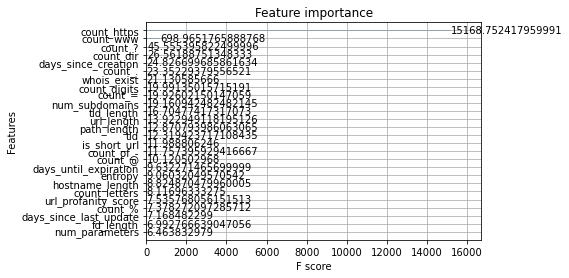

In [73]:
xgb_model = xgb_grid.best_estimator_
from xgboost import plot_importance
plot_importance(xgb_model, importance_type='gain')

In [74]:
f = 'gain'
xgb_model.get_booster().get_score(importance_type= f)

{'count_https': 15168.752417959991,
 'count_www': 698.9651765888768,
 'path_length': 12.870793986063065,
 'days_since_creation': 24.826699685861634,
 'entropy': 9.06032049570542,
 'count_digits': 19.99135015715191,
 'url_length': 13.922949118195126,
 'count_?': 45.555395822499996,
 'days_since_last_update': 7.168482299,
 'num_subdomains': 19.160942482482145,
 'tld': 12.319423717108435,
 'count_.': 23.35229379556521,
 'hostname_length': 8.824870479960005,
 'tld_length': 16.70477417317073,
 'count_%': 7.378272097285712,
 'url_profanity_score': 7.535768056151513,
 'days_until_expiration': 9.632271465699999,
 'count_dir': 26.56188751348333,
 'count_letters': 8.11696333275,
 'fd_length': 6.992766639047056,
 'num_parameters': 6.463832979,
 'count_=': 19.92602150147059,
 'count_of_-': 11.757395929416667,
 'whois_exist': 21.130585666,
 'count_@': 10.120502968,
 'is_short_url': 11.988806246}

In [119]:
# Print ordered feature importance from least to most important
feature_gain_metrics = xgb_model.get_booster().get_score(importance_type= f)
dict(sorted(feature_gain_metrics.items(), key=lambda item: item[1]))

{'whois_exist': 3.1181365405625,
 'fd_length': 3.969750615510741,
 'num_parameters': 4.470240821941176,
 'entropy': 4.689474455392799,
 'days_since_last_update': 5.006483307911362,
 'days_until_expiration': 5.265390386136476,
 'url_profanity_score': 5.473237135330317,
 'count_letters': 5.669058474313635,
 'hostname_length': 7.355512544270007,
 'url_length': 7.426265616444731,
 'is_short_url': 7.52292618188889,
 'count_of_-': 7.543250872427084,
 'count_%': 7.562563770285715,
 'count_@': 7.9855959281111115,
 'path_length': 9.163467952803728,
 'tld': 9.518903725337967,
 'tld_length': 10.269452639970142,
 'count_.': 11.360459637856014,
 'count_=': 13.081700346206897,
 'count_digits': 13.40867798701085,
 'days_since_creation': 15.076387856876956,
 'num_subdomains': 16.766740303967573,
 'count_dir': 17.68555073971764,
 'count_?': 29.254000137545457,
 'count_www': 539.8578018397859,
 'count_https': 14146.759647900164}

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [109]:
# XGBoost classifier with kfold CV
'''
kfold = KFold(n_splits=10)
model = XGBClassifier()
results = cross_val_score(model, x_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
'''

'\nkfold = KFold(n_splits=10)\nmodel = XGBClassifier()\nresults = cross_val_score(model, x_train, y_train, cv=kfold)\nprint("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))\n'

In [110]:
# XGBoost Classifier
xgb_model = XGBClassifier()
xgb_model.fit(x_train,y_train)
xg_predictions = xgb_model.predict(x_test)
accuracy_score(y_test, xg_predictions)

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9979008396641343

In [111]:
cm = pd.DataFrame(confusion_matrix(y_test,xg_predictions))
cm.columns = ['Predicted 0', 'Predicted 1']
cm = cm.rename(index = {0:'Actual 0',1:'Actual 1'})
cm

,Predicted 0,Predicted 1
Actual 0,20637,143
Actual 1,46,69210


## Random forest model

In [112]:
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_predictions = rfc.predict(x_test)
accuracy_score(y_test, rfc_predictions)

0.9977231329690346

In [113]:
cm = pd.DataFrame(confusion_matrix(y_test,rfc_predictions))
cm.columns = ['Predicted 0', 'Predicted 1']
cm = cm.rename(index = {0:'Actual 0',1:'Actual 1'})
cm

,Predicted 0,Predicted 1
Actual 0,20624,156
Actual 1,49,69207


## Logistic regression model

In [114]:
#Logistic Regression
log_model = LogisticRegression()
log_model.fit(x_train,y_train)

log_predictions = log_model.predict(x_test)
accuracy_score(y_test,log_predictions)

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8662757119374472

In [115]:
cm_df = pd.DataFrame(confusion_matrix(y_test,log_predictions))
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index = {0:'Actual 0',1:'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,13147,7633
Actual 1,4407,64849


In [116]:
#Overall Accuracy table
import numpy as np
model = np.array(['XGBClassifier', 'Random Forest', 'Logistic Regression'])
scr = np.array([accuracy_score(y_test,xg_predictions)*100, accuracy_score(y_test, rfc_predictions)*100, accuracy_score(y_test,log_predictions)*100])
tbl = pd.DataFrame({"Model": model,"Accuracy Score": scr})
tbl

,Model,Accuracy Score
0,XGBClassifier,99.790084
1,Random Forest,99.772313
2,Logistic Regression,86.627571


### Save model

In [120]:
import pickle
pickle.dump(xgb_model, open("xgb_model.pickle", "wb"))

In [121]:
# Load back model
loaded_model = pickle.load(open("xgb_model.pickle", "rb"))

In [122]:
x.head()

,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,tld,tld_length,count_of_-,count_@,count_?,count_%,count_.,count_=,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url,url_profanity_score
0,1,8772,743,2549,22,0,14,0,206.0,3,0,0,0,0,2,0,1,1,0,17,0,-3.663533,0,0,0,0,0,0.075126
1,1,6062,250,146,23,0,15,0,206.0,3,0,0,0,0,2,0,1,1,0,18,0,-3.762267,0,0,0,0,0,0.039493
2,1,8942,560,2381,24,0,16,0,206.0,3,0,0,0,0,2,0,1,1,0,19,0,-3.855389,0,0,0,0,0,0.050906
3,1,8016,286,1845,21,0,13,0,206.0,3,0,0,0,0,2,0,1,1,0,16,0,-3.880180,0,0,0,0,0,0.046085
4,1,7557,341,477,25,0,17,0,770.0,3,0,0,0,0,2,0,1,1,0,20,0,-3.813661,0,0,0,0,0,0.096249


In [123]:
# Do a test prediction
y_pred = loaded_model.predict(x.head())

In [124]:
y_pred

array([1, 1, 1, 1, 1])

In [125]:
pd.set_option("display.max_columns", None)
df[df['result'] == 1].head()

,url,result,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,tld,tld_length,count_of_-,count_@,count_?,count_%,count_.,count_=,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url,url_profanity_score
0,https://www.google.com,1,1,8772,743,2549,22,0,14,0,206.0,3,0,0,0,0,2,0,1,1,0,17,0,-3.663533,0,0,0,0,0,0.075126
1,https://www.youtube.com,1,1,6062,250,146,23,0,15,0,206.0,3,0,0,0,0,2,0,1,1,0,18,0,-3.762267,0,0,0,0,0,0.039493
2,https://www.facebook.com,1,1,8942,560,2381,24,0,16,0,206.0,3,0,0,0,0,2,0,1,1,0,19,0,-3.855389,0,0,0,0,0,0.050906
3,https://www.baidu.com,1,1,8016,286,1845,21,0,13,0,206.0,3,0,0,0,0,2,0,1,1,0,16,0,-3.880180,0,0,0,0,0,0.046085
4,https://www.wikipedia.org,1,1,7557,341,477,25,0,17,0,770.0,3,0,0,0,0,2,0,1,1,0,20,0,-3.813661,0,0,0,0,0,0.096249


In [126]:
# Do a test prediction on a single row for a malicious website
values = {
    'whois_exist': [1], 'days_since_creation': [421], 'days_since_last_update': [14], 'days_until_expiration': [81], 
    'url_length': [32], 
    'path_length': [0], 'hostname_length': [25], 'fd_length': [1], 'tld': [759.0], 'tld_length': [6], 
    'count_of_-': [0], 'count_@': [0], 'count_?': [0], 'count_%': [0],'count_.': [1],'count_=': [0],
    'count_https': [0],'count_www': [0],'count_digits': [0],'count_letters': [28],'count_dir': [2],
    'entropy': [-3.8662],'num_parameters': [0],'num_fragments': [0],'num_subdomains': [0],'use_of_ip': [0],
    'is_short_url': [0], 'url_profanity_score': [0.4]
}
test_data = pd.DataFrame.from_dict(values)
test_data

,whois_exist,days_since_creation,days_since_last_update,days_until_expiration,url_length,path_length,hostname_length,fd_length,tld,tld_length,count_of_-,count_@,count_?,count_%,count_.,count_=,count_https,count_www,count_digits,count_letters,count_dir,entropy,num_parameters,num_fragments,num_subdomains,use_of_ip,is_short_url,url_profanity_score
0,1,421,14,81,32,0,25,1,759.0,6,0,0,0,0,1,0,0,0,0,28,2,-3.8662,0,0,0,0,0,0.4


In [127]:
loaded_model.predict(test_data)

array([0])

In [128]:
loaded_model.predict_proba(test_data)

array([[9.9955988e-01, 4.4012014e-04]], dtype=float32)

In [136]:
# Predict for examples where is malicious. Should be 0
df_malicious = df[df['result'] == 0].head()
malicious_rows = df_malicious[['whois_exist', 'days_since_creation',
       'days_since_last_update', 'days_until_expiration', 'url_length',
       'path_length', 'hostname_length', 'fd_length', 'tld', 'tld_length',
       'count_of_-', 'count_@', 'count_?', 'count_%', 'count_.', 'count_=',
       'count_https', 'count_www', 'count_digits', 'count_letters',
       'count_dir', 'entropy', 'num_parameters', 'num_fragments',
       'num_subdomains', 'use_of_ip', 'is_short_url', 'url_profanity_score']]
loaded_model.predict_proba(malicious_rows)

array([[9.9997467e-01, 2.5332165e-05],
       [9.9998516e-01, 1.4834421e-05],
       [9.9999577e-01, 4.2602414e-06],
       [9.9884653e-01, 1.1534535e-03],
       [9.9999690e-01, 3.1126895e-06]], dtype=float32)

In [137]:
loaded_model.predict(malicious_rows)

array([0, 0, 0, 0, 0])

In [140]:
# Predict for examples where is benign. Should be 1
df_benign = df[df['result'] == 1].head()
benign_rows = df_benign[['whois_exist', 'days_since_creation',
       'days_since_last_update', 'days_until_expiration', 'url_length',
       'path_length', 'hostname_length', 'fd_length', 'tld', 'tld_length',
       'count_of_-', 'count_@', 'count_?', 'count_%', 'count_.', 'count_=',
       'count_https', 'count_www', 'count_digits', 'count_letters',
       'count_dir', 'entropy', 'num_parameters', 'num_fragments',
       'num_subdomains', 'use_of_ip', 'is_short_url', 'url_profanity_score']]
loaded_model.predict(benign_rows)

array([1, 1, 1, 1, 1])

### Export ordinal encoders

In [131]:
enc

OrdinalEncoder()

In [132]:
type(enc)

sklearn.preprocessing._encoders.OrdinalEncoder

In [133]:
pickle.dump(enc, open("xgb_model_enc_tld.pkl", "wb"))

In [134]:
# Load back encoder and test it
loaded_enc = pickle.load(open("xgb_model_enc_tld.pkl", "rb"))
type(loaded_enc)

sklearn.preprocessing._encoders.OrdinalEncoder

In [135]:
website = 'abc'
vals = np.array([website])
try: 
    encoded_val = loaded_enc.transform(vals.reshape(-1,1))
except ValueError: 
    print('Value does not exist in encoding')
    value = len(loaded_enc.categories_[0]) + 1
    encoded_val = np.array([[value]])
print(encoded_val)

Value does not exist in encoding
[[1063]]
